from nltk import word_tokenize

In [2]:
import pandas
dataset = pandas.read_csv("../datasets/imdb/imdb_dataset.csv")

In [3]:
topic_dict = {'negative':0, 'positive':1}

In [4]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
words = [w for s in dataset.review for w in word_tokenize(s)]
len(words)

In [5]:
topic_dict.keys()

dict_keys(['negative', 'positive'])

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [10]:
test_dataset.head()

,review,sentiment
0,I caught this show a few times when I was youn...,positive
1,I am a fan of bad horror films of the 1950s an...,negative
2,Dolemite may not have been the first black exp...,positive
3,"Um... Okay, I guess I get the whole shaky-cam,...",negative
4,"Quite simply a well-made, well-written and won...",positive


In [11]:
train_dataset.head()

,review,sentiment
0,"""Everything a great documentary could be""?? Ye...",negative
1,Vijay Krishna Acharya's 'Tashan' is a over-hyp...,negative
2,A young ( only 21 ) director with great talent...,positive
3,Mom should really be given a different title t...,positive
4,"This film is beautiful to look at, but is like...",negative


In [12]:
sum([len(word_tokenize(text)) for text in train_dataset.review]) # /len(train_dataset.text)

9779801

In [13]:
X_train = train_dataset.review
X_test = test_dataset.review

y_train = train_dataset.sentiment
y_test = test_dataset.sentiment

data = train_dataset.append(test_dataset, ignore_index=True)

In [14]:
from nltk.corpus import stopwords
import nltk
import string
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
ps = nltk.stem.PorterStemmer()

def clean_text(data, stem=False, lemmatize=True):  
    data = word_tokenize(data)
    
    remov = set(stopwords.words("english"))
   
    result_words = []
    for w in data:
        temp = w.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))).split()
        result_words.extend(t for t in temp)
        
    words = [word.lower() for word in result_words]
    words = [w.strip() for w in words if '\n' or '' != w]
    words = [w for w in words if w not in remov]
    words = [x for x in words if not any(c.isdigit() for c in x)]
    words = [word for word in words if len(word) > 1]
    words_dum = []
    if lemmatize:
        words = [lemmatizer.lemmatize(w) for w in words]
    if stem:
        words = [ps.stemWord(w) for w in words]
    return words

In [15]:
stem = False
lemmatize = True
texts = [' '.join(clean_text(text,stem, lemmatize)) for text in tqdm(data.review)]

texts_train = [' '.join(clean_text(text,stem, lemmatize)) for text in tqdm(X_train)]
texts_test = [' '.join(clean_text(text,stem, lemmatize)) for text in tqdm(X_test)]

100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:42<00:00, 350.90it/s]


In [16]:
sum([len(word_tokenize(text)) for text in train_dataset.review]) # /len(train_dataset.review)

9779801

In [17]:
embed_num_dims = 300

token_vocab_size = 10000

max_seq_len = 500

class_names = [key for key in topic_dict.keys()]

num_classes = len(class_names)

In [18]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [19]:
tokenizer = Tokenizer(num_words=token_vocab_size)
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 90943


In [20]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len, padding='pre', truncating='pre')
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len, padding='pre', truncating='pre')

X_train_pad

array([[   0,    0,    0, ...,  327, 2824, 1137],
       [   0,    0,    0, ...,  856,  191,  144],
       [   0,    0,    0, ...,  126,  225,  789],
       ...,
       [   0,    0,    0, ..., 1232, 4301,  599],
       [   0,    0,    0, ...,  303,    1,    1],
       [   0,    0,    0, ...,  808,   20,    2]])

In [21]:
y_train = train_dataset.sentiment
y_test = test_dataset.sentiment

In [22]:
import numpy as np

y_train = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_train)))
y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_test)))
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [23]:
from torchtext.vocab import FastText

my_vector = FastText('en')

In [24]:
print(index_of_words['jesus'])

1911


In [25]:
def create_embedding_matrix(w2v_embeds, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word in word_index:
        idx = word_index[word]
        try:
            embed = w2v_embeds[word]
            embedding_matrix[idx] = np.array(
                embed, dtype=np.float32)[:embedding_dim]
        except:
            print(word)
    return embedding_matrix

In [26]:
embedd_matrix = create_embedding_matrix(my_vector, index_of_words, embed_num_dims)
embedd_matrix.shape

(90944, 300)

In [27]:
len(index_of_words)

90943

In [28]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in fasttext vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in fasttext vocab: 79460
New words found: 11483


In [29]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

In [30]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [31]:
# # Convolution
kernel_size = 5
filters = 512

model = Sequential()
model.add(embedd_layer)
model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(filters, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
opt =  keras.optimizers.Adam(lr=0.0005, decay=1e-6)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

In [ ]:
batch_size = 1024
epochs = 10

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test),verbose=1)

In [49]:
model1 = model

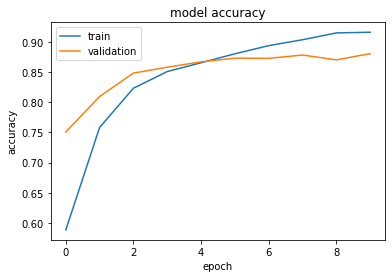

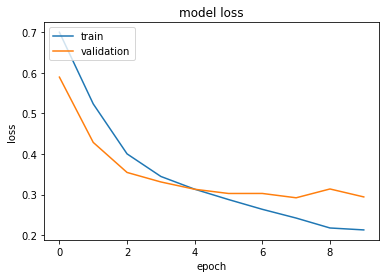

In [35]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('figures/imdb_CNN1D_acc.png')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('figures/imdb_CNN1D_loss.png')
plt.show()

In [356]:
# from keras.models import load_model
# predictor = load_model('models/cnn_w2v.h5')

In [37]:
predictions = model.predict(X_test_pad)
# predictions = np.argmax(predictions, axis=1)
predictions = np.squeeze(predictions)
predictions = np.round(predictions)
predictions

array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [38]:
predictions = [class_names[int(pred)] for pred in predictions]

In [39]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_dataset.sentiment, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_dataset.sentiment, predictions, average='micro') * 100))

Accuracy: 88.04%

F1 Score: 88.04


In [40]:
test_dataset.review[0]

"I caught this show a few times when I was young and it was playing tilt, My parents loved it and now in syndication I feel what they feel. This show did what the original limits and twilight zone (new and old) couldn't do. This show used some old ideas and some truly original ideas.<br /><br />I still cannot believe Jonathan Glassner and brad wright did this. Those guys were producers on stargate sg-1. The show kept the audience entrenched in the story and set a truly scary atmosphere. This is what was not there in the new twilight zone. Rod serling coming in added to the scariness, forest coming in lightened the mood. <br /><br />The ending whether good or bad made for a scary time. You could never predict what was going to happen. I am still trying to find the seasons on DVD."

In [41]:
# import time
# idx = 200
# txt = [test_dataset.text[idx]]
# print(test_dataset.category[idx])
text = """stupid"""
text = clean_text(text)
txt = [text]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_seq_len)
pred = model.predict(padded)
pred = np.squeeze(pred)
labels = ['olumsuz','olumlu'] 
print(labels)
print(pred)
# print(np.argmax(pred))
print(labels[int(np.round(pred))])

['olumsuz', 'olumlu']
0.11203429
olumsuz


In [42]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title,
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

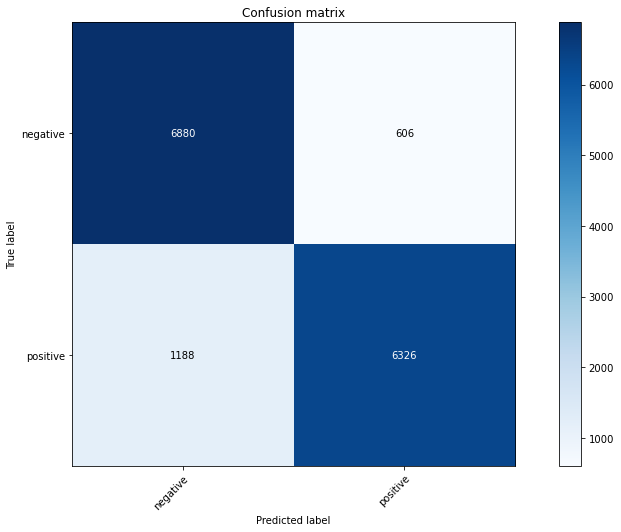

In [45]:
plot_confusion_matrix(test_dataset.sentiment, predictions, classes=class_names, title='Confusion matrix')
# plt.savefig('figures/imdb_CNN1D_confusion.png')
plt.show()

In [46]:
# model.save('models_final/imdb_CNN1D_final.h5')